In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import statsmodels.api as sm

from desiutil.plots import plot_sky_binned
import healpy as hp

NSIDE = 256

In [80]:
df_test_north = pd.read_csv('results/north.csv')
df_test_south = pd.read_csv('results/south.csv')
df_test_des = pd.read_csv('results/des.csv')




In [81]:
df_test_north.describe()

,pixel_id,lrg,elg,qso,exposures,stellar,EBV,airmass,ccdskysb_g,ccdskysb_r,...,seeing_z,lrg_lin,elg_lin,qso_lin,lrg_deep,elg_deep,qso_deep,lrg_nn,elg_nn,qso_nn
count,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,...,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000,19505.000000
mean,92225.883773,35.255217,125.013074,153.388157,0.241988,0.138916,0.135081,0.191441,0.761007,0.621414,...,0.085140,35.296497,124.911223,153.147307,35.388543,125.247744,152.095823,35.742702,126.705088,152.847916
std,52431.908880,11.970088,22.396739,29.051528,0.117935,0.129989,0.129680,0.172791,0.097736,0.090272,...,0.035986,1.768797,8.975664,8.905784,1.779177,10.425933,10.782170,1.778805,9.304531,9.992797
min,1676.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000778,0.000739,0.005608,0.102406,...,0.009702,31.002243,67.929866,104.933991,24.518848,0.256241,36.049149,24.043634,0.000000,55.794102
25%,46904.000000,27.000000,111.000000,133.000000,0.181818,0.058577,0.049559,0.049132,0.717752,0.572679,...,0.062168,34.220784,120.715764,147.633220,34.251625,120.697037,142.851883,34.483624,121.840973,146.860291
50%,90608.000000,34.000000,124.000000,152.000000,0.209790,0.087866,0.083774,0.134943,0.777599,0.635442,...,0.080854,34.760544,125.847317,153.274758,34.927025,125.993736,150.651016,35.127621,127.080925,153.105423
75%,137175.000000,41.000000,139.000000,172.000000,0.244755,0.167364,0.177612,0.282249,0.829016,0.682651,...,0.102415,35.928599,130.295280,159.138528,36.255074,131.418030,161.891022,36.745148,131.961945,160.499496
max,186638.000000,131.000000,285.000000,314.000000,1.000000,0.979079,0.982179,0.775222,0.974139,1.000000,...,1.000000,44.207563,204.662816,194.513427,43.500221,179.823257,182.639252,42.653908,167.424225,179.188843


In [82]:
zscore = lambda x: abs((x - x.median()) / x.std())

df_test_north['ELG_Z_deep'] = df_test_north['elg'] - df_test_north['elg_deep']
df_test_north['ELG_Z_deep'] = df_test_north['ELG_Z_deep'].transform(zscore)
df_test_north['ELG_Z_nn'] = df_test_north['elg'] - df_test_north['elg_nn']
df_test_north['ELG_Z_nn'] = df_test_north['ELG_Z_deep'].transform(zscore)
df_test_north['ELG_Z_lin'] = df_test_north['elg'] - df_test_north['elg_lin']
df_test_north['ELG_Z_lin'] = df_test_north['ELG_Z_deep'].transform(zscore)

print(df_test_north['ELG_Z_deep'])

0        1.999433
1        1.287141
2        1.287255
3        1.245969
4        0.802212
           ...   
19500    0.303964
19501    0.091100
19502    0.255578
19503    1.319875
19504    0.566612
Name: ELG_Z_deep, Length: 19505, dtype: float64


In [85]:
df = df_test_north[df_test_north['ELG_Z_deep'] < 1]
df_diff = df[df['ELG_Z_lin'] > 1]
df_no_diff = df[df['ELG_Z_lin'] <= 1]

print(len(df_diff))
print(len(df_no_diff))

df_lala = df_diff.describe() - df_no_diff.describe()

df_lala.columns

130
13644


Index(['pixel_id', 'lrg', 'elg', 'qso', 'exposures', 'stellar', 'EBV',
       'airmass', 'ccdskysb_g', 'ccdskysb_r', 'ccdskysb_z', 'exptime_g',
       'exptime_r', 'exptime_z', 'meansky_g', 'meansky_r', 'meansky_z',
       'seeing_g', 'seeing_r', 'seeing_z', 'lrg_lin', 'elg_lin', 'qso_lin',
       'lrg_deep', 'elg_deep', 'qso_deep', 'lrg_nn', 'elg_nn', 'qso_nn',
       'ELG_Z_deep', 'ELG_Z_nn', 'ELG_Z_lin'],
      dtype='object')

In [91]:
import math
from scipy.stats import t

n1, n2 = len(df_diff), len(df_no_diff)

for col in df_diff:
    m1 = df_diff[col].mean()
    m2 = df_no_diff[col].mean()
    std1 = df_diff[col].std()
    std2 = df_no_diff[col].std()

    se1, se2 = std1 / math.sqrt(n1), std2 / math.sqrt(n2)
    sed = math.sqrt(se1 ** 2.0 + se2 ** 2.0)
    t_stat = (m1 - m2) / sed

    dof = n1 + n2 - 2

    cv = t.ppf(1.0 - 0.05, dof)
    p = (1.0 - t.cdf(abs(t_stat), dof)) * 2.0

    print(col, p)
    print()


pixel_id 0.47439605286094544

lrg 0.8519173259927841

elg 0.15322685259692737

qso 0.7728603220851189

exposures 0.5742314960940367

stellar 0.775924482044789

EBV 0.8095553676297245

airmass 0.8465999007546925

ccdskysb_g 0.49161620894575186

ccdskysb_r 0.9183648964347817

ccdskysb_z 0.3470660429292436

exptime_g 0.2967371446156517

exptime_r 0.9128311722159879

exptime_z 0.6566528821874935

meansky_g 0.3701680670227332

meansky_r 0.6806541947366755

meansky_z 0.4568683398623423

seeing_g 0.1930330749770217

seeing_r 0.20530088228376853

seeing_z 0.8706257030833475

lrg_lin 0.7644576634787068

elg_lin 0.543253676452133

qso_lin 0.10243600263404007

lrg_deep 0.5688579876209978

elg_deep 0.3078418666406655

qso_deep 0.6179853798154906

lrg_nn 0.6566642324931875

elg_nn 0.21703288506690366

qso_nn 0.2688212624556763

ELG_Z_deep 0.0

ELG_Z_nn 0.0

ELG_Z_lin 0.0



In [ ]:
df_test_north["sig_Z_lin"] = df_test_north['ELG_Z_deep'] - df_test_north['ELG_Z_lin']
df_test_north["sig_Z_lin"] = df_test_north['sig_Z_lin'].transform(zscore)

df_no_diff = df_test_north[df_test_north['sig_Z_lin'] <= 1]
df_diff = df_test_north[df_test_north['sig_Z_lin'] > 1]
print(len(df_test_north), len(df_diff) + len(df_no_diff))

In [50]:
print(df_diff.describe())

            pixel_id          lrg          elg          qso    exposures  \
count    4885.000000  4885.000000  4885.000000  4885.000000  4885.000000   
mean    92165.712794    35.375844   126.259365   153.817810     0.240776   
std     52167.657230    12.177939    21.545375    30.286564     0.119636   
min      1782.000000     1.000000     1.000000     1.000000     0.000000   
25%     47383.000000    28.000000   119.000000   134.000000     0.181818   
50%     90582.000000    34.000000   125.000000   153.000000     0.209790   
75%    137120.000000    41.000000   131.000000   172.000000     0.244755   
max    186601.000000   131.000000   285.000000   284.000000     1.000000   

           stellar          EBV      airmass   ccdskysb_g   ccdskysb_r  ...  \
count  4885.000000  4885.000000  4885.000000  4885.000000  4885.000000  ...   
mean      0.140166     0.135833     0.190316     0.763017     0.622423  ...   
std       0.132053     0.132835     0.171993     0.096507     0.091726  ...   

In [51]:
print(df_no_diff.describe())

            pixel_id           lrg           elg           qso     exposures  \
count   14620.000000  14620.000000  14620.000000  14620.000000  14620.000000   
mean    92245.988782     35.214911    124.596648    153.244596      0.242393   
std     52521.670184     11.899977     22.659527     28.626620      0.117363   
min      1676.000000      1.000000      1.000000      2.000000      0.013986   
25%     46835.500000     27.000000    108.000000    133.000000      0.181818   
50%     90623.500000     34.000000    123.000000    152.000000      0.209790   
75%    137194.000000     41.000000    142.000000    171.000000      0.244755   
max    186638.000000    131.000000    205.000000    314.000000      0.986014   

            stellar           EBV       airmass    ccdskysb_g    ccdskysb_r  \
count  14620.000000  14620.000000  14620.000000  14620.000000  14620.000000   
mean       0.138498      0.134830      0.191817      0.760335      0.621077   
std        0.129294      0.128613      0.1

In [53]:

df_lala = (df_diff.describe() - df_no_diff.describe())

print(df_lala.columns)

          pixel_id          lrg          elg          qso    exposures  \
count -9735.000000 -9735.000000 -9735.000000 -9735.000000 -9735.000000   
mean    -80.275988     0.160933     1.662717     0.573213    -0.001618   
std    -354.012955     0.277962    -1.114152     1.659944     0.002273   
min     106.000000     0.000000     0.000000    -1.000000    -0.013986   
25%     547.500000     1.000000    11.000000     1.000000     0.000000   
50%     -41.500000     0.000000     2.000000     1.000000     0.000000   
75%     -74.000000     0.000000   -11.000000     1.000000     0.000000   
max     -37.000000     0.000000    80.000000   -30.000000     0.013986   

           stellar          EBV      airmass   ccdskysb_g   ccdskysb_r  ...  \
count -9735.000000 -9735.000000 -9735.000000 -9735.000000 -9735.000000  ...   
mean      0.001668     0.001004    -0.001501     0.002681     0.001347  ...   
std       0.002760     0.004223    -0.001069    -0.001630     0.001945  ...   
min       0.00000

In [61]:
y_gold = df_diff.elg
y_pred = df_diff.elg_deep
print(f"Deep Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")
print()
y_gold = df_diff.elg
y_pred = df_diff.elg_lin
print(f"Linear Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")
print()
y_gold = df_diff.elg
y_pred = df_diff.elg_nn
print(f"NN Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")

Deep Regression R^2:  0.27565992568107933.

Linear Regression R^2:  0.158660999385435.

NN Regression R^2:  0.24114887869003987.


In [62]:
y_gold = df_no_diff.elg
y_pred = df_no_diff.elg_deep
print(f"Deep Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")
print()
y_gold = df_no_diff.elg
y_pred = df_no_diff.elg_lin
print(f"Linear Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")
print()
y_gold = df_no_diff.elg
y_pred = df_no_diff.elg_nn
print(f"NN Regression R^2:  {metrics.r2_score(y_gold, y_pred)}.")



Deep Regression R^2:  0.2762591695325983.

Linear Regression R^2:  0.16509796728029658.

NN Regression R^2:  0.19552599990203445.


## Plotting the differences between the networks


In [45]:

df_test_north = pd.read_csv('results/north_complete.csv')
df_test_south = pd.read_csv('results/south_complete.csv')
df_test_des = pd.read_csv('results/des_complete.csv')
df_test_north.drop(columns=['y_gold_y', 'y_gold_x', 'y_gold'], inplace=True)
df_test_south.drop(columns=['y_gold_y', 'y_gold_x', 'y_gold'], inplace=True)
df_test_des.drop(columns=['y_gold_y', 'y_gold_x', 'y_gold'], inplace=True)

### DES ELG Maps at resolution NSIDE = 64

In [70]:
area = 'south'
gal = 'qso'

df_test = pd.read_csv(f'results/{area}_complete.csv')


In [71]:
#df_test[f'{gal}_LINEAR_VS_NN'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_nn']
df_test[f'{gal}_LINEAR_VS_DEEP'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_deep']
#df_test[f'{gal}_NN_VS_DEEP'] = df_test[f'{gal}_nn'] - df_test[f'{gal}_deep']

df_test[f'{gal}_GOLD_VS_LINEAR'] = df_test[f'{gal}'] - df_test[f'{gal}_lin']
#df_test[f'{gal}_GOLD_VS_NN'] = df_test[f'{gal}'] - df_test[f'{gal}_nn']
df_test[f'{gal}_GOLD_VS_DEEP'] = df_test[f'{gal}'] - df_test[f'{gal}_deep']


"ax3 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_NN_VS_DEEP'], cmap='bwr', label=f'{area}_{gal}_NN_VS_DEEP',\n                      plot_type=plott, verbose=verb, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)"

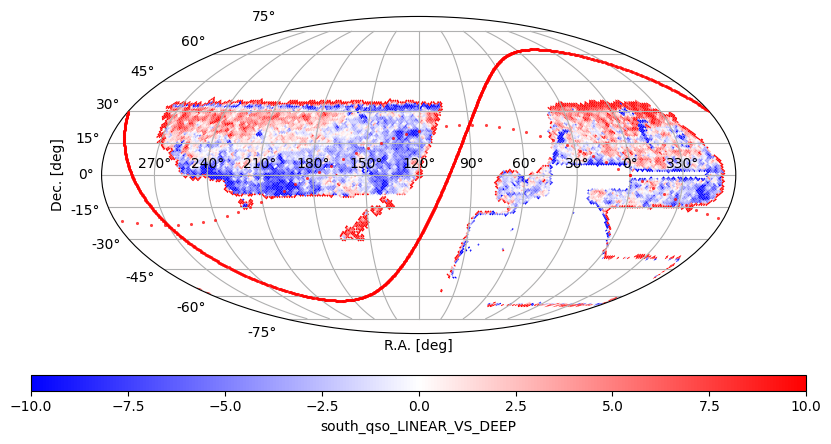

In [72]:
verb = False
plott = 'healpix'
bin_area = 2
ra, dec = hp.pix2ang(NSIDE, df_test.pixel_id, lonlat=True)
clipper = 10
"""ax1 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_LINEAR_VS_NN'], cmap='bwr', label=f'{area}_{gal}_LINEAR_VS_NN',
                      plot_type=plott, verbose=verb, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)"""

ax2 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_LINEAR_VS_DEEP'], cmap='bwr', label=f'{area}_{gal}_LINEAR_VS_DEEP',
                      plot_type=plott, verbose=verb, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

"""ax3 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_NN_VS_DEEP'], cmap='bwr', label=f'{area}_{gal}_NN_VS_DEEP',
                      plot_type=plott, verbose=verb, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)"""

In [77]:
clipper = 33
print()

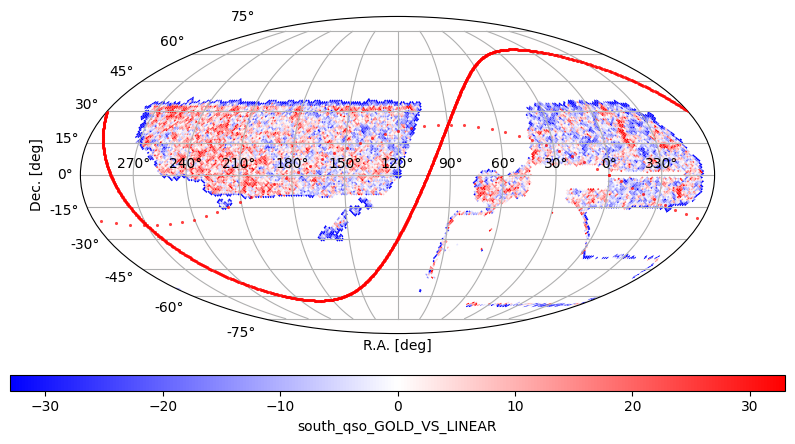

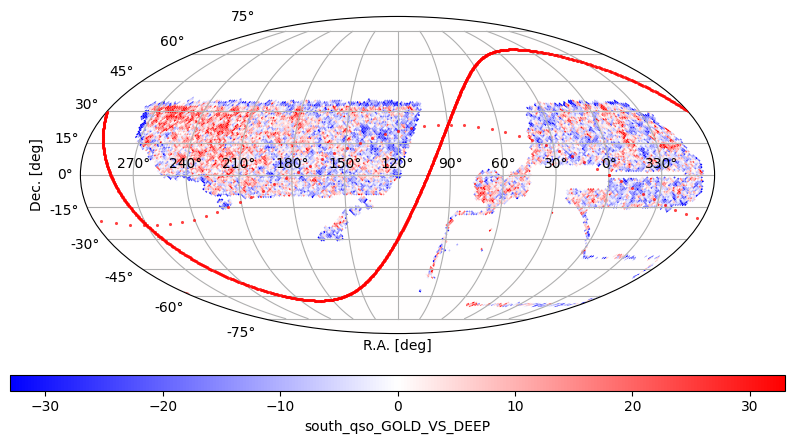

In [78]:
ax4 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_GOLD_VS_LINEAR'], cmap='bwr', label=f'{area}_{gal}_GOLD_VS_LINEAR',
                      plot_type=plott, verbose=verb, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

"""ax5 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_GOLD_VS_NN'], cmap='bwr', label=f'{area}_{gal}_GOLD_VS_NN',
                      plot_type=plott, verbose=verb, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)"""

ax6 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_GOLD_VS_DEEP'], cmap='bwr', label=f'{area}_{gal}_GOLD_VS_DEEP',
                      plot_type=plott, verbose=verb, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

In [ ]:
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()

### Approximated DES ELG Maps at resolution  NSIDE = 64

In [2]:
area = 'north'
gal = 'elg'

df_test = pd.read_csv(f'results/{area}_complete.csv')


In [3]:
df_test[f'{gal}_LINEAR_VS_NN'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_nn']
df_test[f'{gal}_LINEAR_VS_DEEP'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_deep']
df_test[f'{gal}_NN_VS_DEEP'] = df_test[f'{gal}_nn'] - df_test[f'{gal}_deep']

df_test[f'{gal}_GOLD_VS_LINEAR'] = df_test[f'{gal}'] - df_test[f'{gal}_lin']
df_test[f'{gal}_GOLD_VS_NN'] = df_test[f'{gal}'] - df_test[f'{gal}_nn']
df_test[f'{gal}_GOLD_VS_DEEP'] = df_test[f'{gal}'] - df_test[f'{gal}_deep']


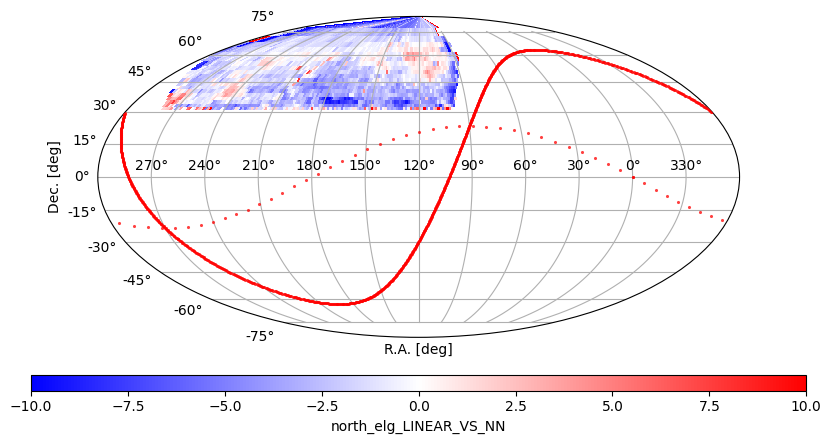

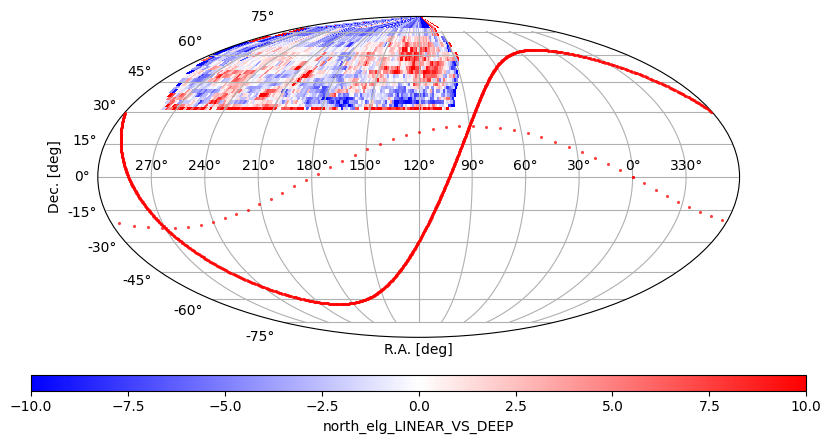

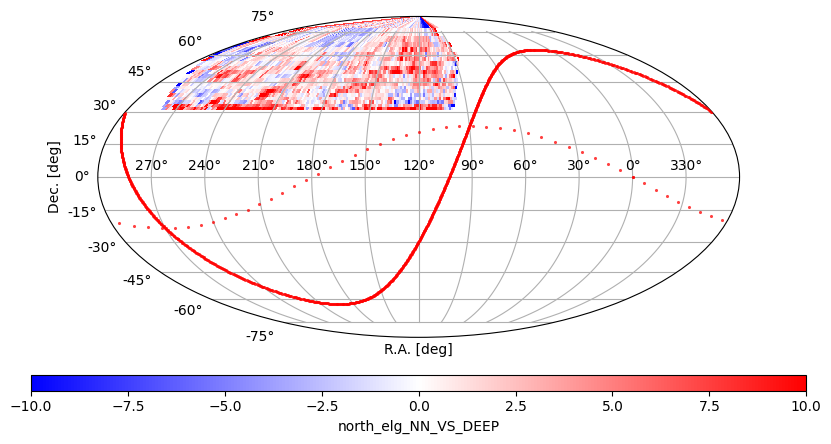

In [4]:
bin_area = 2
ra, dec = hp.pix2ang(NSIDE, df_test.pixel_id, lonlat=True)
clipper = 10
ax1 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_LINEAR_VS_NN'], cmap='bwr', label=f'{area}_{gal}_LINEAR_VS_NN',
                      plot_type='grid', verbose=False, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

ax2 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_LINEAR_VS_DEEP'], cmap='bwr', label=f'{area}_{gal}_LINEAR_VS_DEEP',
                      plot_type='grid', verbose=False, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

ax3 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_NN_VS_DEEP'], cmap='bwr', label=f'{area}_{gal}_NN_VS_DEEP',
                      plot_type='grid', verbose=False, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

In [140]:
clipper = 20
print()

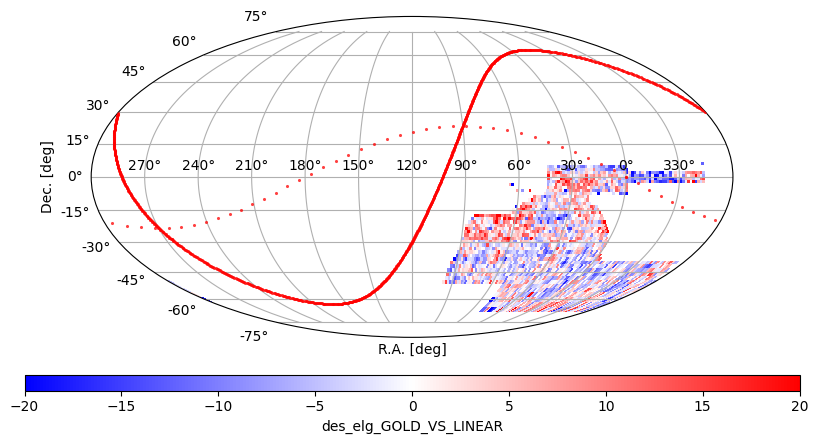

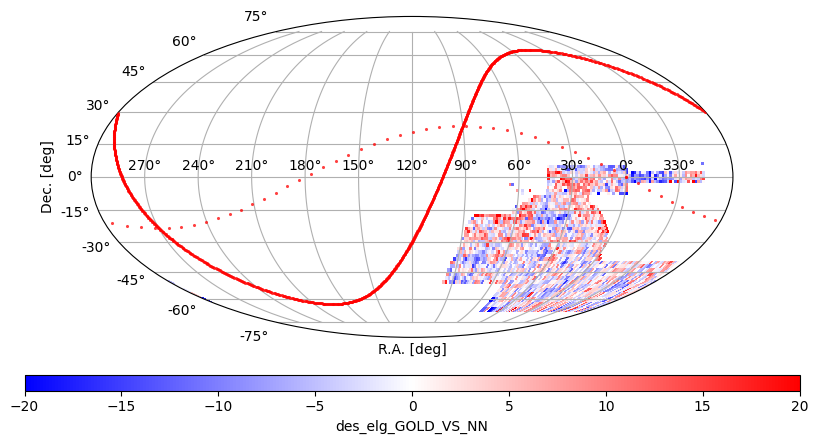

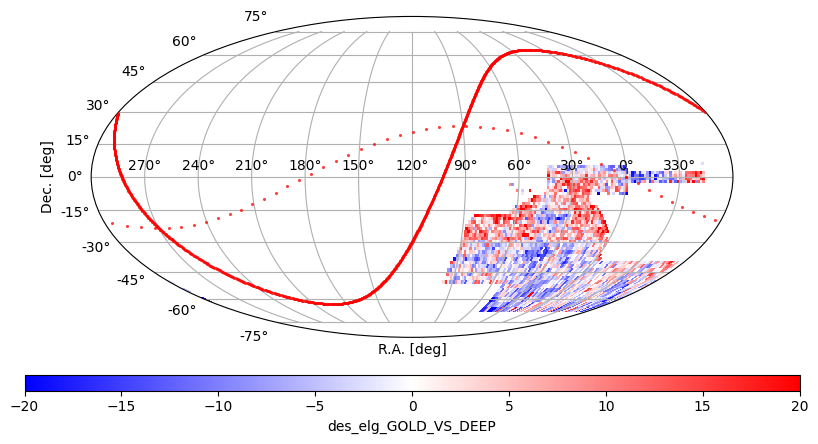

In [141]:
ax4 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_GOLD_VS_LINEAR'], cmap='bwr', label=f'{area}_{gal}_GOLD_VS_LINEAR',
                      plot_type='grid', verbose=False, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

ax5 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_GOLD_VS_NN'], cmap='bwr', label=f'{area}_{gal}_GOLD_VS_NN',
                      plot_type='grid', verbose=False, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

ax6 = plot_sky_binned(ra, dec, data=df_test[f'{gal}_GOLD_VS_DEEP'], cmap='bwr', label=f'{area}_{gal}_GOLD_VS_DEEP',
                      plot_type='grid', verbose=False, max_bin_area=bin_area, clip_lo=-clipper, clip_hi=clipper)

In [131]:
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()
print()

#### Numerical Quantification of Linear vs Deep Differences


In [41]:
gals = ['lrg', 'elg', 'qso']



# NORTH

In [42]:
area = 'north'

for gal in gals:
    df_test = pd.read_csv(f'results/{area}_complete.csv')

    df_test[f'{gal}_LINEAR_VS_NN'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_nn']
    df_test[f'{gal}_LINEAR_VS_DEEP'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_deep']
    df_test[f'{gal}_NN_VS_DEEP'] = df_test[f'{gal}_nn'] - df_test[f'{gal}_deep']

    df_test[f'{gal}_GOLD_VS_LINEAR'] = df_test[f'{gal}'] - df_test[f'{gal}_lin']
    df_test[f'{gal}_GOLD_VS_NN'] = df_test[f'{gal}'] - df_test[f'{gal}_nn']
    df_test[f'{gal}_GOLD_VS_DEEP'] = df_test[f'{gal}'] - df_test[f'{gal}_deep']

    y = df_test[f'{gal}_LINEAR_VS_DEEP']
    X = df_test.drop(columns=['pixel_id', 'lrg', 'elg', 'qso',
                              'lrg_lin', 'elg_lin', 'qso_lin',
                              'lrg_nn', 'elg_nn', 'qso_nn', 'lrg_deep', 'y_gold_x', 'elg_deep',
                              'y_gold_y', 'qso_deep', 'y_gold', f'{gal}_LINEAR_VS_NN', f'{gal}_LINEAR_VS_DEEP',
                              f'{gal}_NN_VS_DEEP', f'{gal}_GOLD_VS_LINEAR',
                              f'{gal}_GOLD_VS_NN', f'{gal}_GOLD_VS_DEEP'])

    ols = sm.OLS(y, X).fit()
    print()
    print()
    print()
    print(f'++++++++++++++++++++++++++++++++++       {gal}       ++++++++++++++++++++++++++++++++++')
    print()
    print()
    print()
    print(ols.summary())
    print()
    print()
    print()




++++++++++++++++++++++++++++++++++       lrg       ++++++++++++++++++++++++++++++++++



                                 OLS Regression Results                                
Dep. Variable:     lrg_LINEAR_VS_DEEP   R-squared (uncentered):                   0.228
Model:                            OLS   Adj. R-squared (uncentered):              0.228
Method:                 Least Squares   F-statistic:                              1799.
Date:                Tue, 02 Nov 2021   Prob (F-statistic):                        0.00
Time:                        11:26:42   Log-Likelihood:                     -1.3388e+05
No. Observations:               97512   AIC:                                  2.678e+05
Df Residuals:                   97496   BIC:                                  2.680e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                 coef    std

# SOUTH

In [43]:
area = 'south'

for gal in gals:
    df_test = pd.read_csv(f'results/{area}_complete.csv')

    df_test[f'{gal}_LINEAR_VS_NN'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_nn']
    df_test[f'{gal}_LINEAR_VS_DEEP'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_deep']
    df_test[f'{gal}_NN_VS_DEEP'] = df_test[f'{gal}_nn'] - df_test[f'{gal}_deep']

    df_test[f'{gal}_GOLD_VS_LINEAR'] = df_test[f'{gal}'] - df_test[f'{gal}_lin']
    df_test[f'{gal}_GOLD_VS_NN'] = df_test[f'{gal}'] - df_test[f'{gal}_nn']
    df_test[f'{gal}_GOLD_VS_DEEP'] = df_test[f'{gal}'] - df_test[f'{gal}_deep']

    y = df_test[f'{gal}_LINEAR_VS_DEEP']
    X = df_test.drop(columns=['pixel_id', 'lrg', 'elg', 'qso',
                              'lrg_lin', 'elg_lin', 'qso_lin',
                              'lrg_nn', 'elg_nn', 'qso_nn', 'lrg_deep', 'y_gold_x', 'elg_deep',
                              'y_gold_y', 'qso_deep', 'y_gold', f'{gal}_LINEAR_VS_NN', f'{gal}_LINEAR_VS_DEEP',
                              f'{gal}_NN_VS_DEEP', f'{gal}_GOLD_VS_LINEAR',
                              f'{gal}_GOLD_VS_NN', f'{gal}_GOLD_VS_DEEP'])

    ols = sm.OLS(y, X).fit()
    print()
    print()
    print()
    print(f'++++++++++++++++++++++++++++++++++       {gal}       ++++++++++++++++++++++++++++++++++')
    print()
    print()
    print()
    print(ols.summary())
    print()
    print()
    print()




++++++++++++++++++++++++++++++++++       lrg       ++++++++++++++++++++++++++++++++++



                                 OLS Regression Results                                
Dep. Variable:     lrg_LINEAR_VS_DEEP   R-squared (uncentered):                   0.131
Model:                            OLS   Adj. R-squared (uncentered):              0.131
Method:                 Least Squares   F-statistic:                              1750.
Date:                Tue, 02 Nov 2021   Prob (F-statistic):                        0.00
Time:                        11:26:45   Log-Likelihood:                     -4.0018e+05
No. Observations:              185699   AIC:                                  8.004e+05
Df Residuals:                  185683   BIC:                                  8.006e+05
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                 coef    std

# DES

In [44]:
area = 'des'

for gal in gals:
    df_test = pd.read_csv(f'results/{area}_complete.csv')

    df_test[f'{gal}_LINEAR_VS_NN'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_nn']
    df_test[f'{gal}_LINEAR_VS_DEEP'] = df_test[f'{gal}_lin'] - df_test[f'{gal}_deep']
    df_test[f'{gal}_NN_VS_DEEP'] = df_test[f'{gal}_nn'] - df_test[f'{gal}_deep']

    df_test[f'{gal}_GOLD_VS_LINEAR'] = df_test[f'{gal}'] - df_test[f'{gal}_lin']
    df_test[f'{gal}_GOLD_VS_NN'] = df_test[f'{gal}'] - df_test[f'{gal}_nn']
    df_test[f'{gal}_GOLD_VS_DEEP'] = df_test[f'{gal}'] - df_test[f'{gal}_deep']

    y = df_test[f'{gal}_LINEAR_VS_DEEP']
    X = df_test.drop(columns=['pixel_id', 'lrg', 'elg', 'qso',
                              'lrg_lin', 'elg_lin', 'qso_lin',
                              'lrg_nn', 'elg_nn', 'qso_nn', 'lrg_deep', 'y_gold_x', 'elg_deep',
                              'y_gold_y', 'qso_deep', 'y_gold', f'{gal}_LINEAR_VS_NN', f'{gal}_LINEAR_VS_DEEP',
                              f'{gal}_NN_VS_DEEP', f'{gal}_GOLD_VS_LINEAR',
                              f'{gal}_GOLD_VS_NN', f'{gal}_GOLD_VS_DEEP'])

    ols = sm.OLS(y, X).fit()
    print()
    print()
    print()
    print(f'++++++++++++++++++++++++++++++++++       {gal}       ++++++++++++++++++++++++++++++++++')
    print()
    print()
    print()
    print(ols.summary())
    print()
    print()
    print()




++++++++++++++++++++++++++++++++++       lrg       ++++++++++++++++++++++++++++++++++



                                 OLS Regression Results                                
Dep. Variable:     lrg_LINEAR_VS_DEEP   R-squared (uncentered):                   0.883
Model:                            OLS   Adj. R-squared (uncentered):              0.883
Method:                 Least Squares   F-statistic:                          4.086e+04
Date:                Tue, 02 Nov 2021   Prob (F-statistic):                        0.00
Time:                        11:26:47   Log-Likelihood:                         -31721.
No. Observations:               86589   AIC:                                  6.347e+04
Df Residuals:                   86573   BIC:                                  6.362e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                 coef    std